# 2D Medical Image Attack


### Startup

In [17]:
import cv2
import time
import numpy as np  

try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

import math

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [18]:


#Change CFG Case

cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah", "case/user=multiuser_aggregate"])
#cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah","case/user=local_gradient"])
#cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah","case/user=local_updates"])

  
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [19]:
# UserType

#cfg.case.user.user_type ='local_gradient'


#cfg.case.user.user_type ='local_update'
#cfg.case.user.num_local_updates=4


#cfg.case.user.user_type ='multiuser_aggregate'

In [20]:






cfg.case.data.name = "BrainTumor"
cfg.case.data.default_clients = 6
cfg.case.data.classes = 2


cfg.case.user.num_data_points = 16 # How many data points does this user own
cfg.case.data.batch_size = 4
cfg.case.server.model_modification.type = 'CuriousAbandonHonesty' # What type of Imprint block will be grafted to the model
cfg.case.server.model_modification.num_bins = 128 # How many bins are in the block

cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'addition'

#Unnormalized data:
cfg.case.data.normalize = False
cfg.case.server.model_modification.mu = 0
cfg.case.server.model_modification.sigma = 0.5
cfg.case.server.model_modification.scale_factor = 1 - 0.990
cfg.attack.breach_reduction = None # Will be done manually



### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [21]:

print (cfg.case.user.user_type)
print (cfg.case.user)

multiuser_aggregate
{'user_type': 'multiuser_aggregate', 'user_range': [0, 4], 'num_data_points': 16, 'provide_buffers': False, 'provide_labels': False, 'provide_num_data_points': True, 'local_diff_privacy': {'gradient_noise': 0.0, 'input_noise': 0.0, 'distribution': 'laplacian', 'per_example_clipping': 0.0}, 'num_local_updates': 1, 'num_data_per_local_update_step': 1, 'local_learning_rate': 0.001, 'provide_local_hyperparams': False}


In [22]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

First layer determined to be model.stem.0
Block inserted at feature shape torch.Size([3, 224, 224]).
loss_fn RecursiveScriptModule(original_name=CrossEntropyLoss)
cfg_case {'data': {'db': {'name': None}, 'name': 'BrainTumor', 'modality': 'vision', 'task': 'classification', 'path': '~/data/imagenet', 'size': 1281167, 'classes': 2, 'shape': [3, 224, 224], 'normalize': False, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'augmentations_train': {'RandomResizedCrop': 224, 'RandomHorizontalFlip': 0.5}, 'augmentations_val': {'Resize': 256, 'CenterCrop': 224}, 'default_clients': 6, 'partition': 'balanced', 'examples_from_split': 'validation', 'batch_size': 4, 'caching': False}, 'impl': {'shuffle': False, 'sample_with_replacement': False, 'dtype': 'float', 'non_blocking': True, 'sharing_strategy': 'file_descriptor', 'enable_gpu_acc': False, 'benchmark': True, 'deterministic': False, 'pin_memory': True, 'threads': 0, 'persistent_workers': False, 'mixed_precision': False, 'grad_sca

In [23]:
model

VisionContainer(
  (model): ResNet(
    (stem): Sequential(
      (0): Sequential(
        (0): CuriousAbandonHonesty(
          (linear0): Linear(in_features=150528, out_features=128, bias=True)
          (nonlin): ReLU()
        )
        (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layers): Sequential(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (nonlin): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
      

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [24]:
server_payload = server.distribute_payload()

shared_data, true_user_data = user.compute_local_updates(server_payload)  



Computing user update on user 0 in model mode: eval.
Computing user update on user 1 in model mode: eval.
Computing user update on user 2 in model mode: eval.
Computing user update on user 3 in model mode: eval.


NRRD file saved at: reconstructed_processed.nrrd


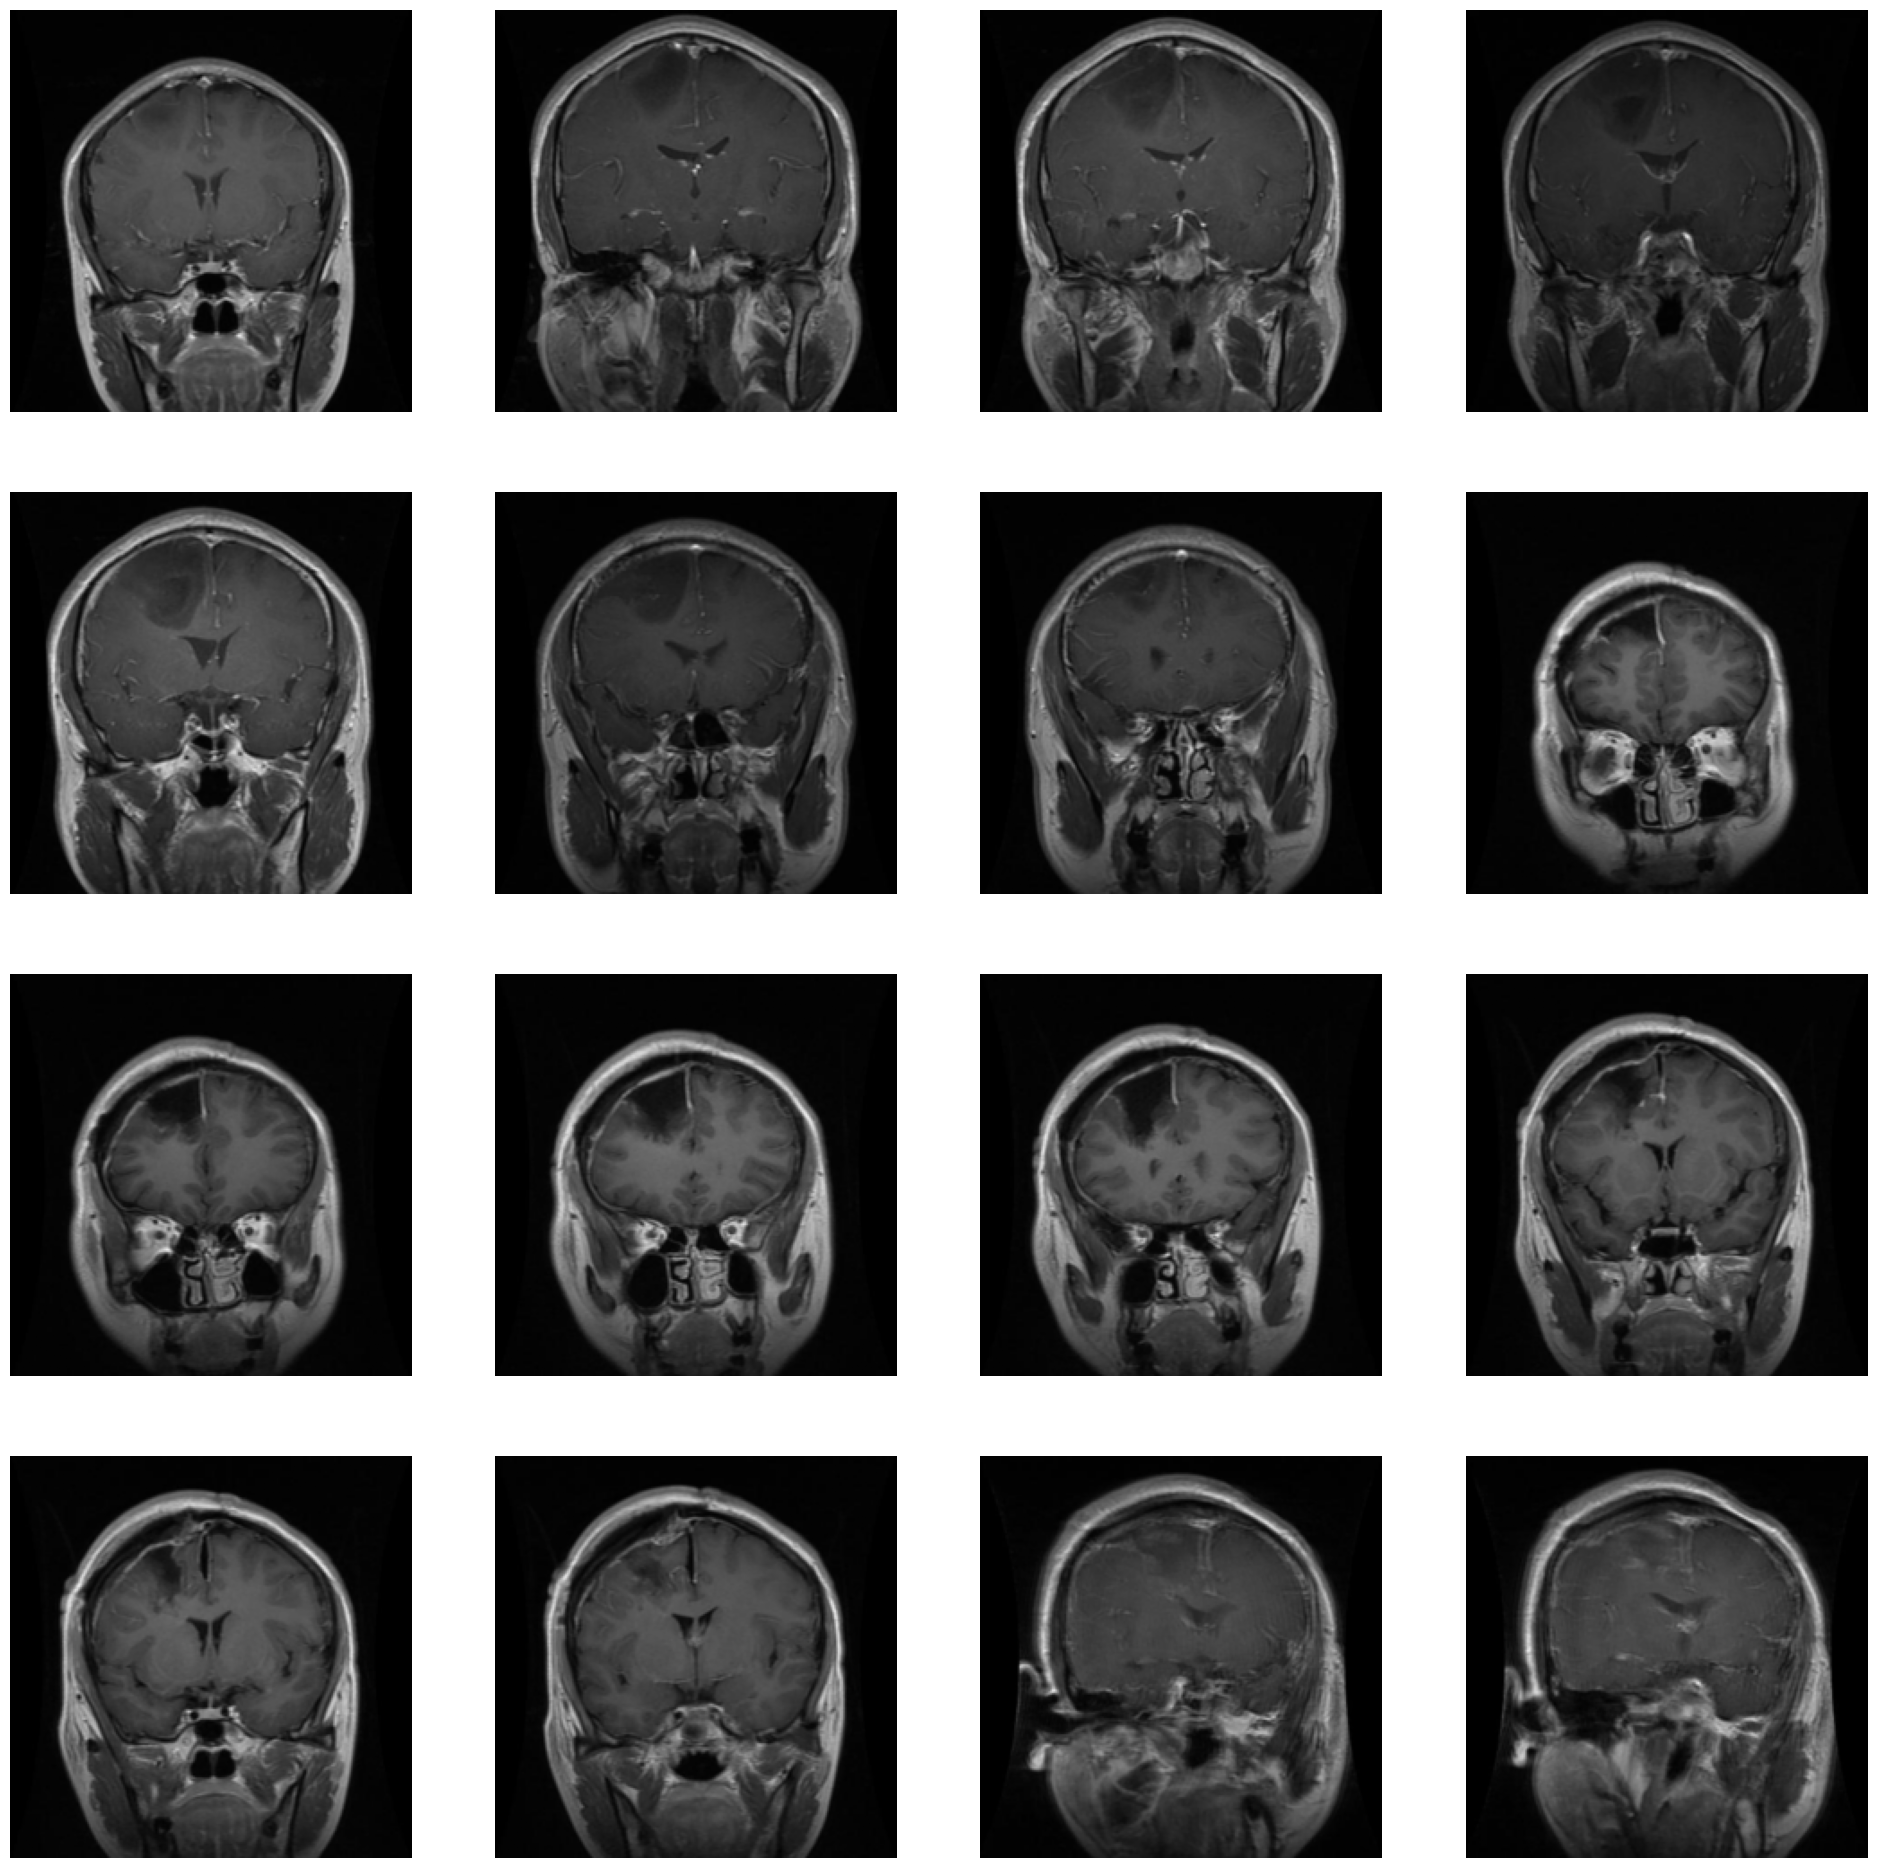

In [25]:
user.plot(true_user_data)

In [26]:
type(true_user_data)
len(true_user_data['data'])

16

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

For this attack, we also share secret information from the malicious server with the attack (`server.secrets`), which here is the location and structure of the imprint block.

In [27]:
local_time = time.time()
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 117 hits.


In [28]:
len(reconstructed_user_data['data'])

117

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

### Remove mixed images by direct GT comparison

In [29]:
reconstructed = torch.zeros_like(true_user_data["data"])
for sample in reconstructed_user_data["data"]:
        l2_dists = (sample[None] - true_user_data["data"]).pow(2).mean(dim=[1, 2, 3])
        min_dist, min_idx = l2_dists.min(dim=0)
        if min_dist < 1e-1:
            reconstructed[min_idx] = sample
reconstructed_user_data = dict(data=reconstructed, labels=None)

In [30]:
#metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                   #server.model, order_batch=True, compute_full_iip=False, 
                                    #cfg_case=cfg.case, setup=setup)

And finally, we also plot the reconstructed data:

NRRD file saved at: reconstructed_processed.nrrd


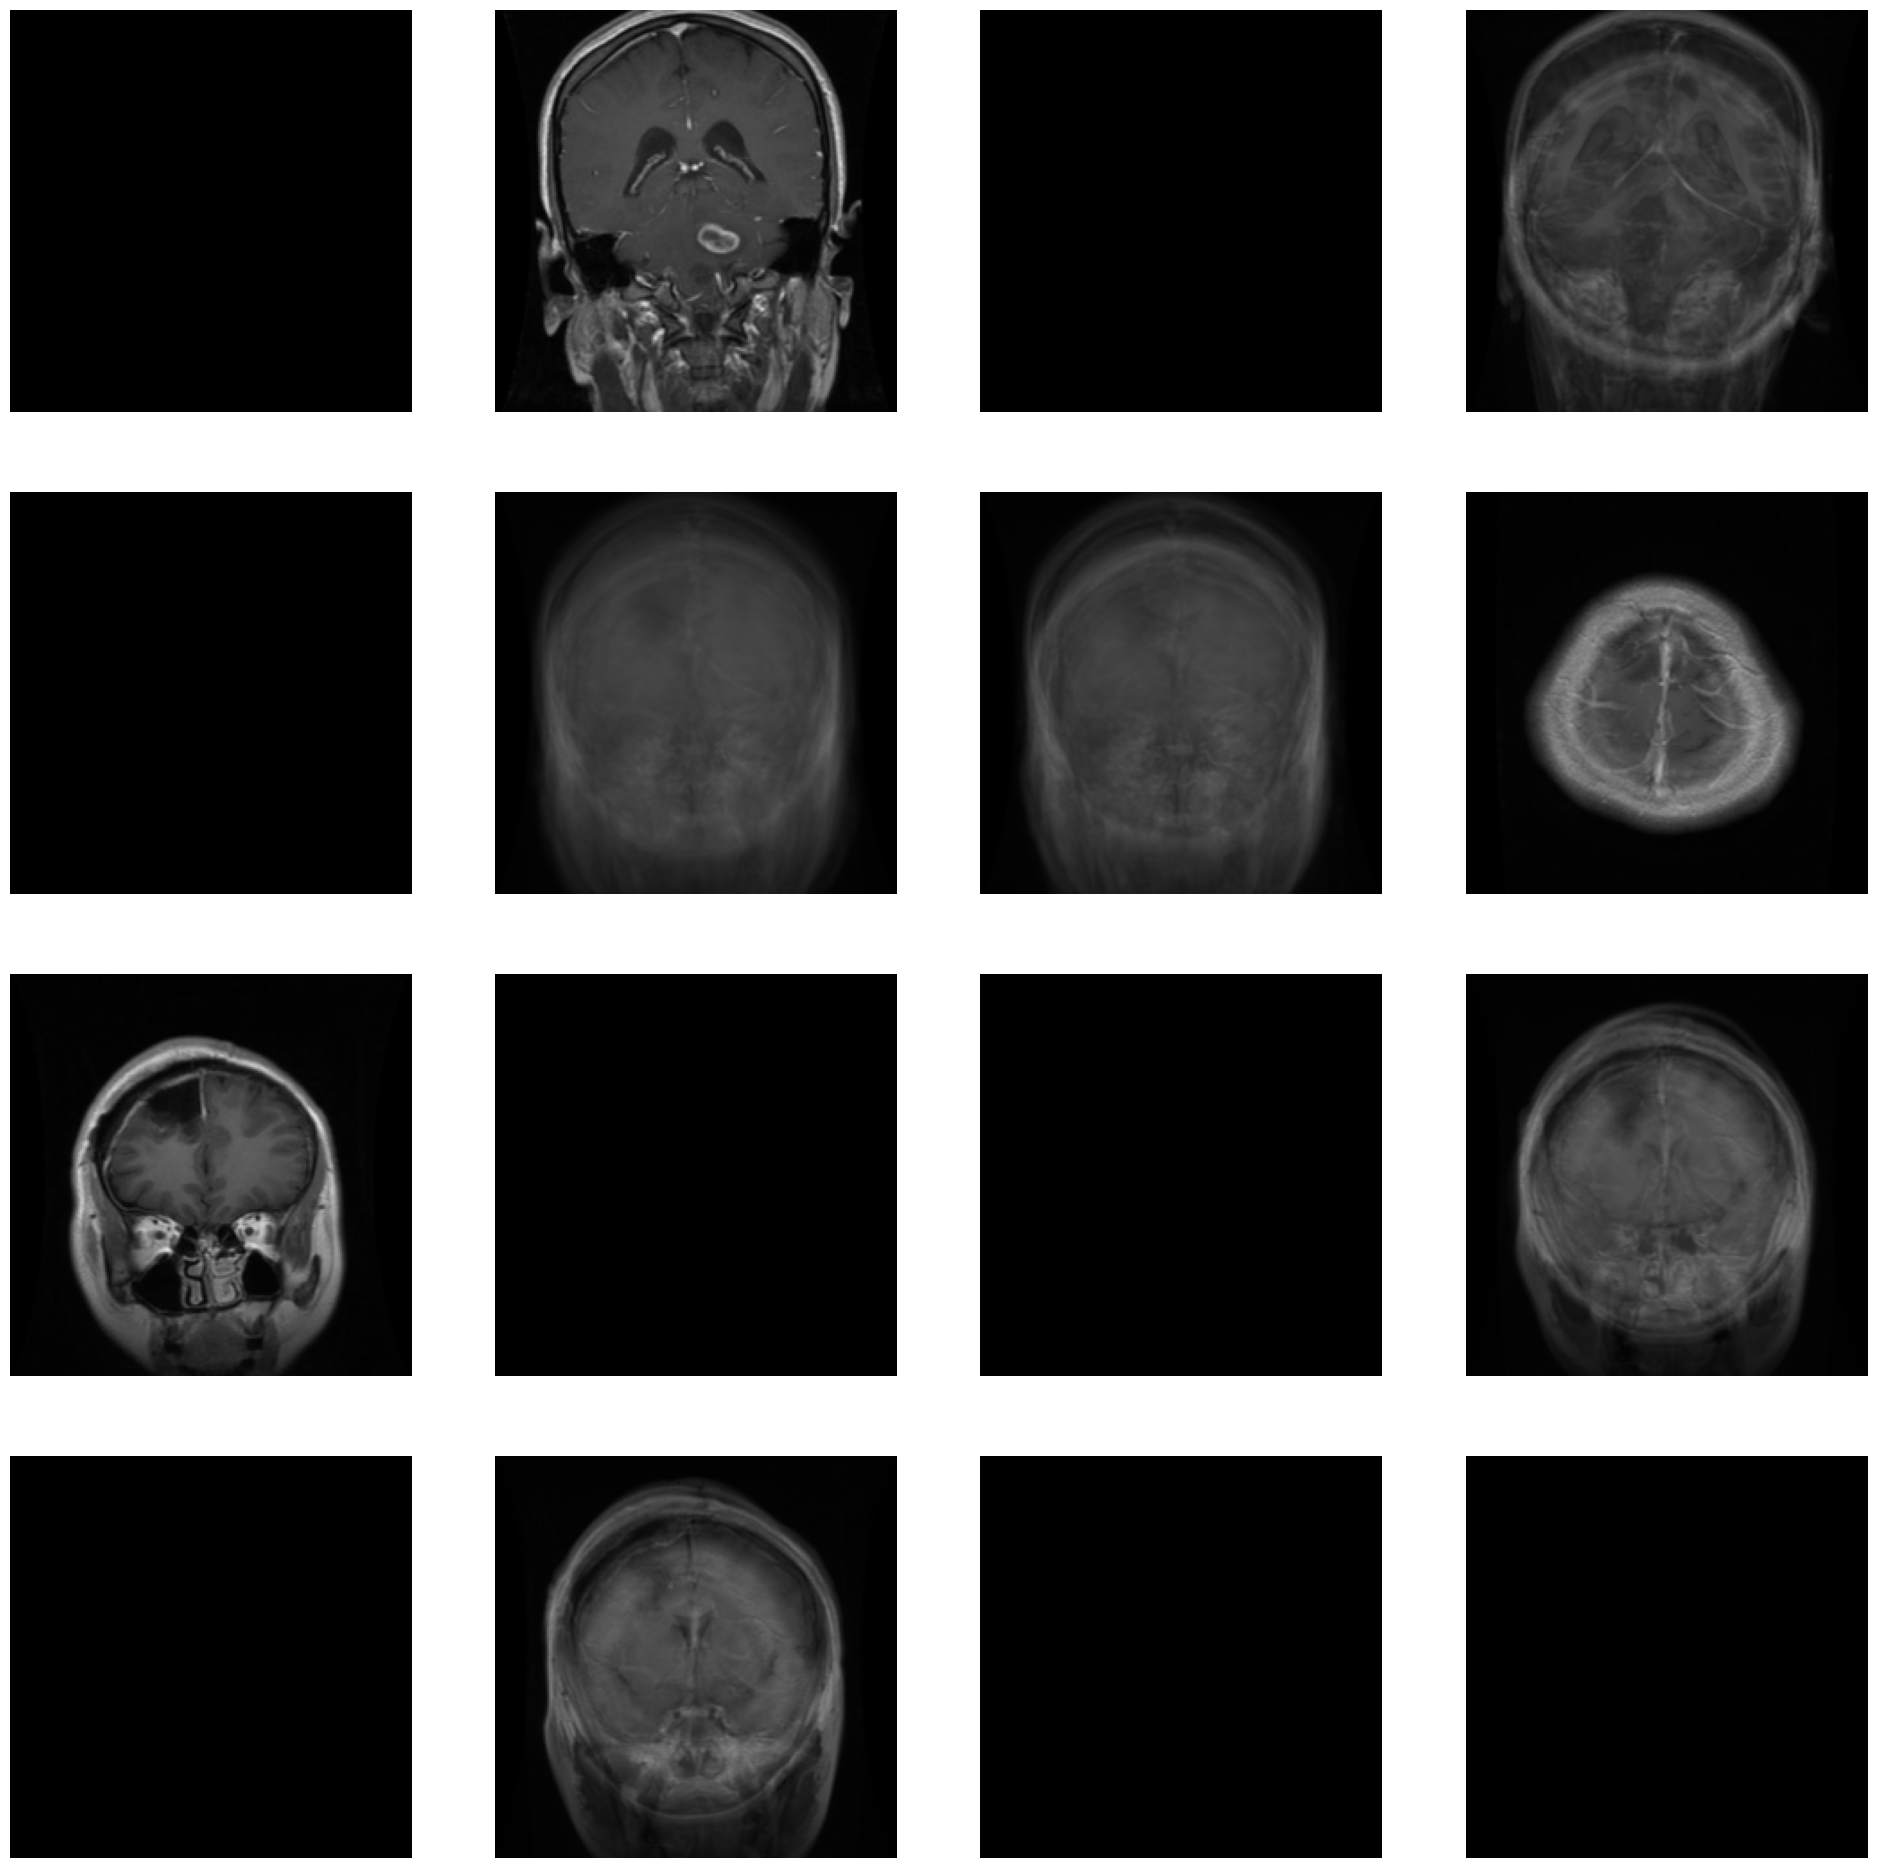

In [31]:
user.plot(reconstructed_user_data)

In [ ]:
#breaching.utils.dump_metrics(cfg, metrics)
#if cfg.save_reconstruction:
import breaching
import time
breaching.utils.save_reconstruction(reconstructed_user_data, [server_payload], true_user_data, cfg,side_by_side=True)

In [ ]:
#breaching.utils.save_summary(cfg, metrics, stats, local_time, original_cwd=False, table_name="breach")


In [ ]:
#breaching.utils.overview(server,user,attacker)

Model architecture ResNet18 loaded with 30,438,596 parameters and 9,620 buffers.
Overall this is a data ratio of      13:1 for target shape [16, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 16

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: BrainTumor
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).
